In [150]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md
import pandas as pd


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
print(os.getcwd())

/home/t/chem101


In [3]:
pdb='/home/t/chem101/Villin_Lab/2F4K.protein.pdb'
trajectory='/home/t/chem101/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/home/t/chem101/Villin_Lab/2f4K.xray.CA.pdb'
outdir='/home/t/chem101/Villin_Lab/'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /home/t/chem101/Villin_Lab/
pdb: /home/t/chem101/Villin_Lab/2F4K.protein.pdb
trjaectory: /home/t/chem101/Villin_Lab/2F4K.protein.s10.dcd


In [4]:
stride_sel=10
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [5]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [6]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [7]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [8]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


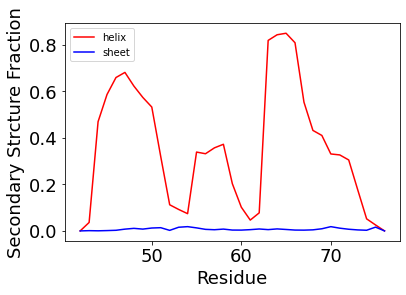

In [9]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [10]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [11]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [12]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




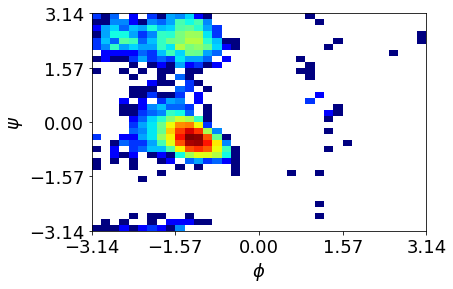

In [13]:
plot_phipsi(45)


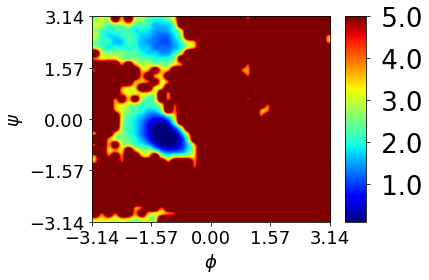

In [14]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(45)

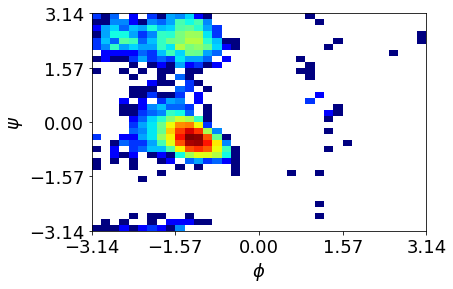

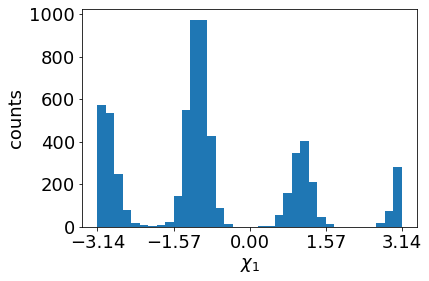

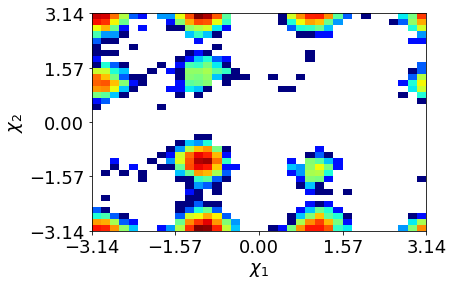

In [15]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [16]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [17]:
len(resid_xray)

70

In [42]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x7fe2d9f908e0>

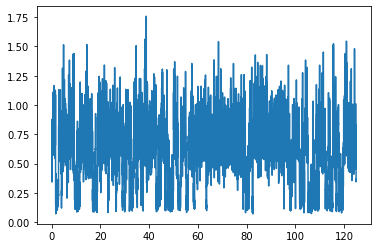

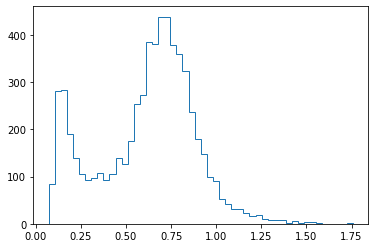

In [47]:
CA_trj_sel=trj.topology.select("name CA")
CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [20]:
native_frames=np.where(rmsd<0.25)[0]
len(native_frames)


1016

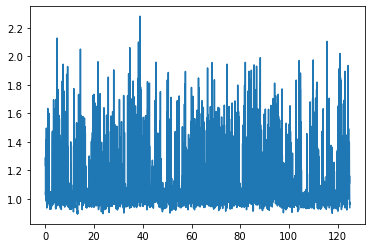

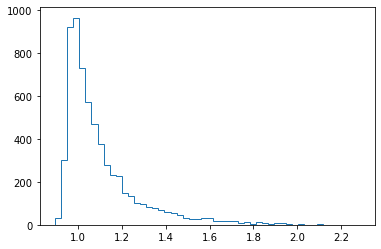

In [21]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [22]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


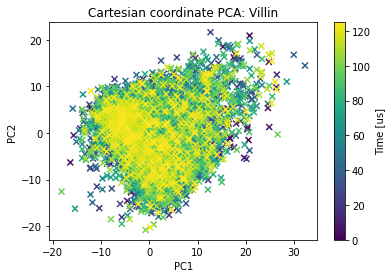

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

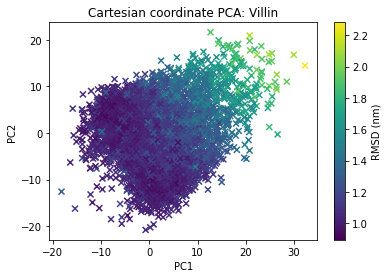

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

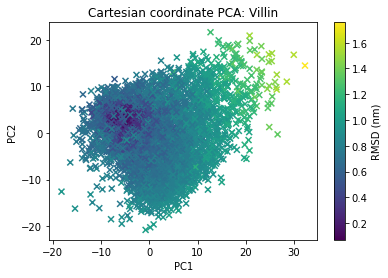

In [25]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

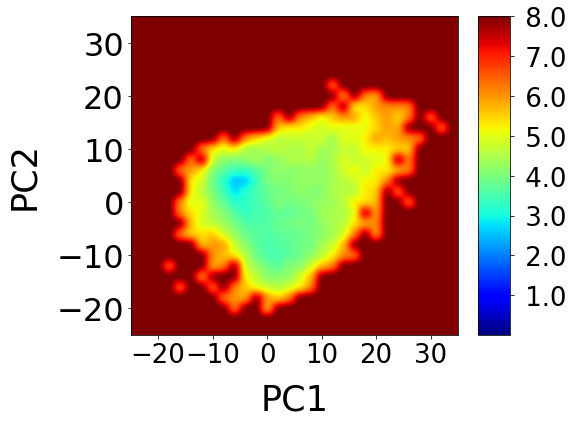

In [26]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [27]:
#Lets Plot Free Energies as a function of RMSD and Rg


*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

In [28]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [29]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

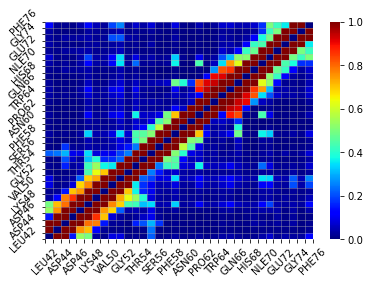

In [30]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [31]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [32]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [33]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

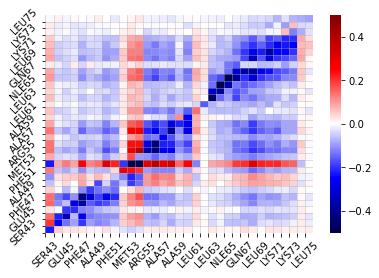

In [34]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

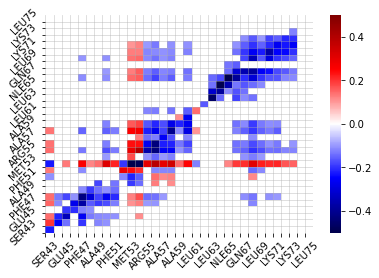

In [35]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

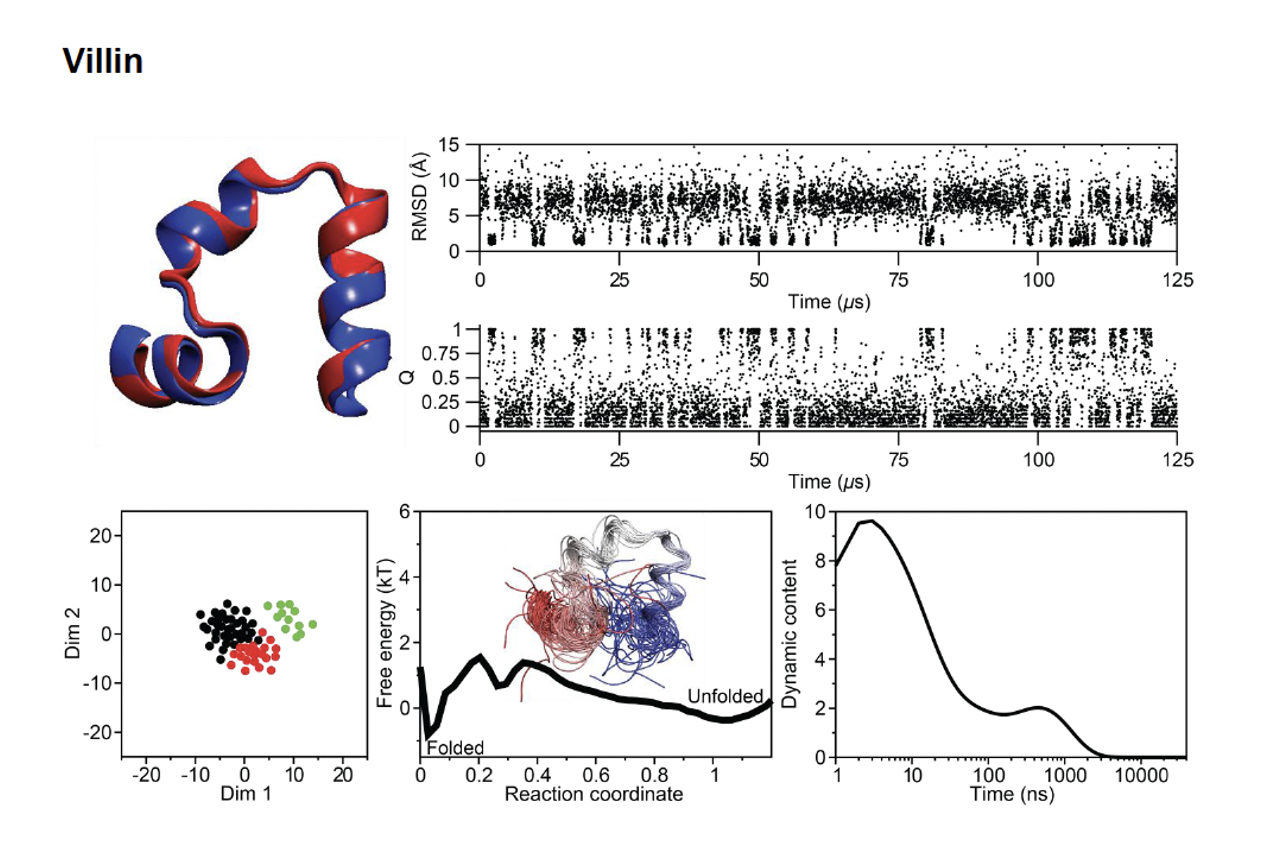

In [207]:
os.getcwd()

'/home/t/chem101'

First we need to determine the native contacts and calculate Q

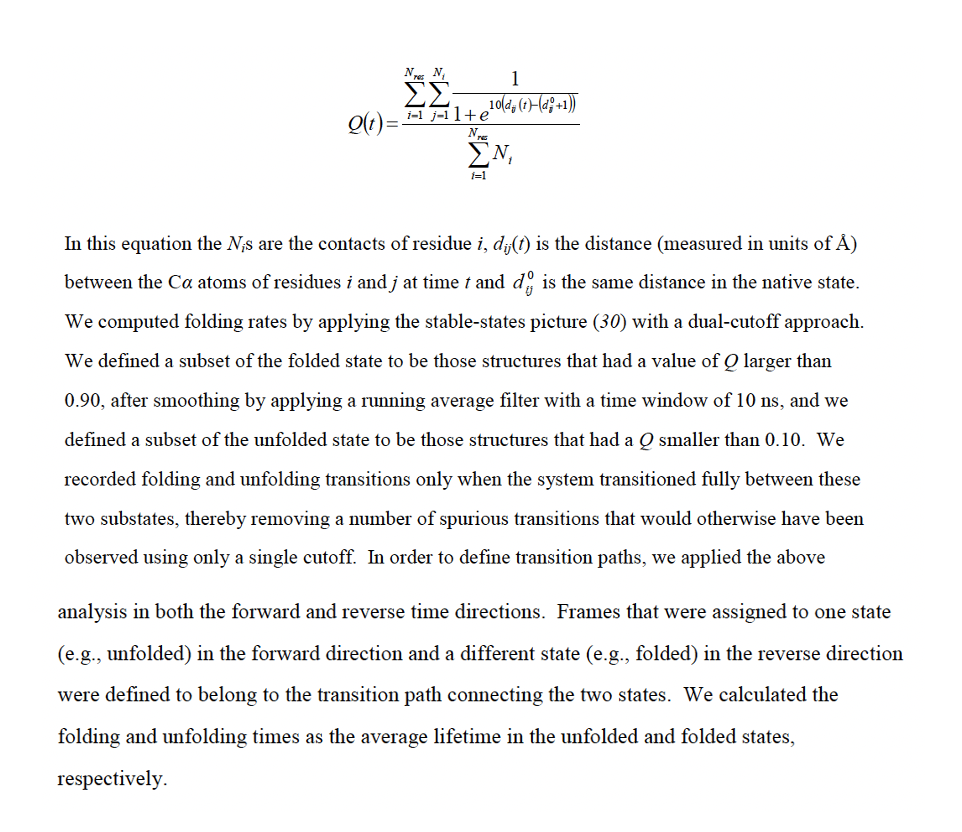

initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

native cluster: 1
Native Contact Pairs: ['LEU42-CA,ARG55-CA' 'SER43-CA,THR54-CA' 'SER43-CA,ARG55-CA'
 'ASP44-CA,MET53-CA' 'ASP44-CA,THR54-CA' 'ASP44-CA,ARG55-CA'
 'ASP44-CA,SER56-CA' 'GLU45-CA,MET53-CA' 'GLU45-CA,THR54-CA'
 'GLU45-CA,ARG55-CA' 'ASP46-CA,THR54-CA' 'ASP46-CA,ARG55-CA'
 'PHE47-CA,ARG55-CA' 'PHE47-CA,PHE58-CA' 'VAL50-CA,NLE70-CA'
 'VAL50-CA,LYS73-CA' 'VAL50-CA,LEU75-CA' 'PHE51-CA,LEU69-CA'
 'PHE51-CA,NLE70-CA' 'PHE51-CA,LYS73-CA' 'MET53-CA,ASP44-CA'
 'MET53-CA,GLU45-CA' 'THR54-CA,SER43-CA' 'THR54-CA,ASP44-CA'
 'THR54-CA,GLU45-CA' 'THR54-CA,ASP46-CA' 'ARG55-CA,LEU42-CA'
 'ARG55-CA,SER43-CA' 'ARG55-CA,ASP44-CA' 'ARG55-CA,GLU45-CA'
 'ARG55-CA,ASP46-CA' 'ARG55-CA,PHE47-CA' 'SER56-CA,ASP44-CA'
 'PHE58-CA,PHE47-CA' 'PHE58-CA,GLN66-CA' 'PHE58-CA,LEU69-CA'
 'GLN66-CA,PHE58-CA' 'GLN67-CA,PHE76-CA' 'LEU69-CA,PHE51-CA'
 'LEU69-CA,PHE58-CA' 'NLE70-CA,VAL50-CA' 'NLE70-CA,PHE51-CA'
 'LYS73-CA,VAL50-CA' 'LYS73-CA,PHE51-CA' 'LEU75-CA,VAL50-CA'
 'PHE76-CA,GLN67-CA']


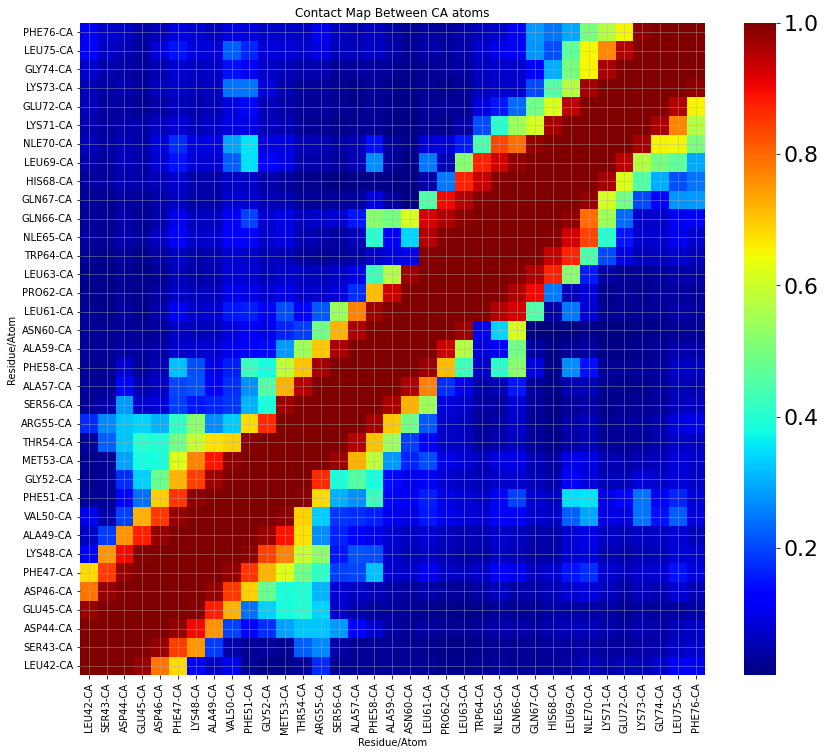

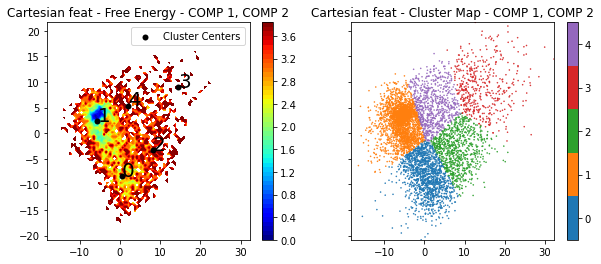

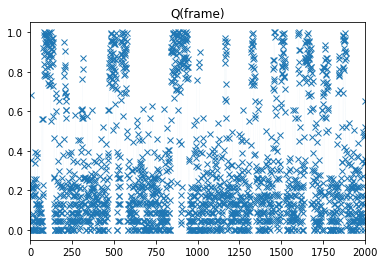

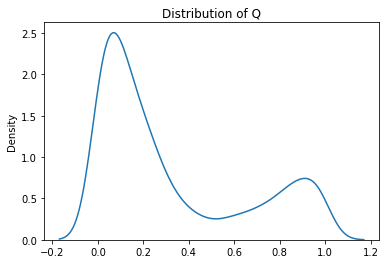

/tmp/ipykernel_25085/2108994729.py:170: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rmsd = md.rmsd(trj,helix,atom_indices=sel)


0.8450761859196487 0.15105743611313446
11.360664 4.5071473


(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

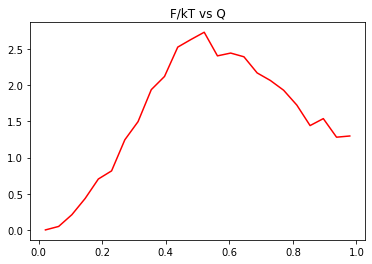

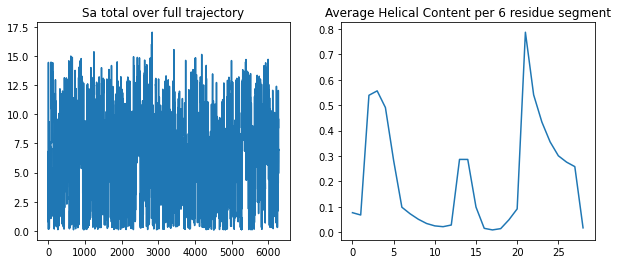

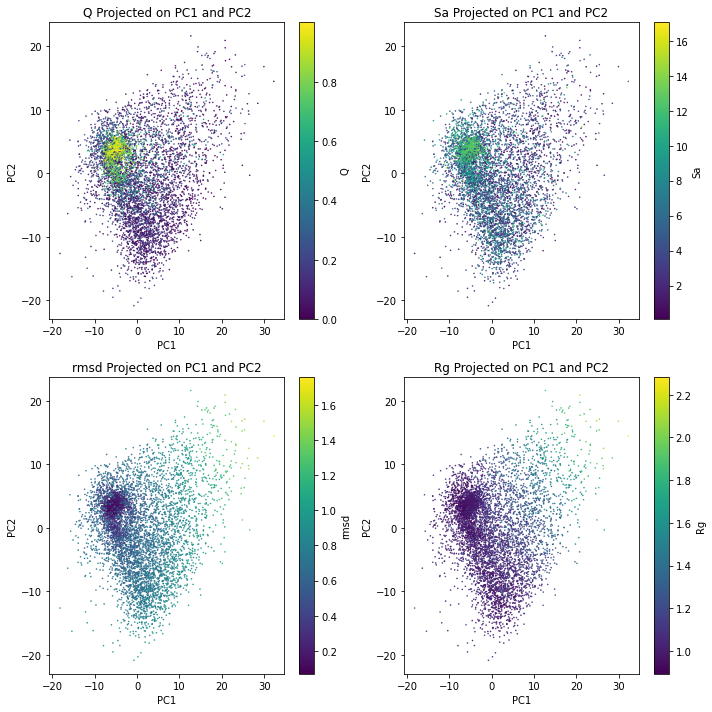

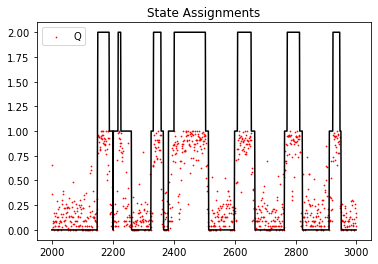

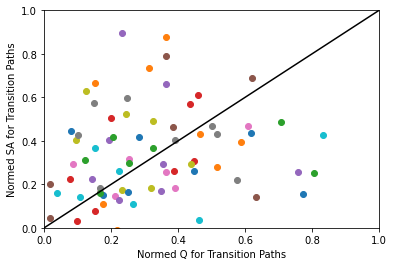

In [206]:
def distance_matrix(sel1,sel2,offset1,offset2,traj,measure,periodic):
    pair_distances = []
    pairs = []
    pairs_res_index = []
    if measure == "residues":
        index = ["{}".format(traj.topology.residue(i)) for i in sel1]
        columns = ["{}".format(traj.topology.residue(j)) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.residue(i),traj.topology.residue(j)))
                pairs_res_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_contacts(traj,[[i,j]],periodic=periodic)[0][:,0]
                    pair_distances.append(dist)
    if measure == "atoms":
        index = ["{}".format(traj.topology.atom(i)) for i in sel1]
        columns = ["{}".format(traj.topology.atom(j)) for j in sel2]
        for i in sel1:
            for j in sel2:
                pairs.append("{},{}".format(traj.topology.atom(i),traj.topology.atom(j)))
                pairs_res_index.append([i+offset1,j+offset2])
                if i==j:
                    dist = np.zeros(traj.n_frames)
                    pair_distances.append(dist)
                else:
                    dist = md.compute_distances(traj,[[i,j]],periodic=periodic)[:,0]
                    pair_distances.append(dist)
    dist_feat_arr = np.stack(pair_distances,axis=1)
    return dist_feat_arr,np.array(pairs),np.stack(pairs_res_index,axis=0),index,columns,len(sel1),len(sel2)

sel1 = list(range(35))
sel2=sel1
dist_feat_arr,pairs,pairs_index_arr,index,columns,x,y=distance_matrix(sel1,sel2,0,0,trjCA,measure="atoms",periodic=True)
xray_dist= distance_matrix(np.arange(xray.n_atoms),np.arange(xray.n_atoms),0,0,xray_CA,measure="atoms",periodic=True)[0]
xray_dist = xray_dist.flatten()

#define helper functions
def Q(dist_arr,d0):
    q_ = []
    for i in range(dist_arr.shape[0]):
        d = dist_arr[i]
        q = np.sum(1/(1+np.exp(100*(d-(d0+.1)))),axis=0)/dist_arr.shape[1]
        q_.append(q)
    return np.array(q_)

def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>=space]+i*(nres))
    return np.hstack(l)

def df_to_heatmap(df,title,xlabel,ylabel):
    fig = plt.figure(figsize=(14,12))
    ax = fig.add_subplot(111)
    im = sns.heatmap(df,cmap="jet",ax=ax)
    ax.grid(which="both",alpha=0.5)
    cbar = im.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)
    ax.set_title("{}".format(title))
    ax.set_ylabel("{}".format(ylabel))
    ax.set_xlabel("{}".format(xlabel))
    return

#plot heatmap
binary = np.where(dist_feat_arr<1,1,0)
binary_sum = np.sum(binary,axis=0)
data = binary_sum.reshape(x,y)/dist_feat_arr.shape[0]
df = pd.DataFrame(data=np.flip(data,axis=0),index=index[::-1],columns=columns)
df_to_heatmap(df,"Contact Map Between CA atoms","Residue/Atom","Residue/Atom")

#cluster
k=5 
import pyemma.coordinates as coor
cluster = coor.cluster_kmeans(reduced_cartesian, k = k,max_iter=50)
dtraj = cluster.dtrajs[0]
clustercenters = cluster.clustercenters
frames_cl = []
cl_fraction = []
for i in range(5):
    frames = np.where(dtraj==i)[0]
    frames_cl.append(frames)
    cl_fraction.append(len(frames)/len(dtraj))

print("native cluster:",np.argmax(np.array(cl_fraction))) 

#calculate free energy of TICS
f_=np.histogram2d(reduced_cartesian[:,0],reduced_cartesian[:,1],bins=100)[0]
f[f==0] = .01
e = -np.log(f)
e = e - e.min()
mask=np.ma.array(e.T, mask=np.where(e.T==e.T.max(),True,False))

#prepare plot
cs = []
for i in range(k):
    c = 'C{}'.format(i)
    cs.append(c)
cmap = colors.ListedColormap(cs)
boundaries = arange(k+1).tolist()
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
tick_locs = (np.arange(k) + 0.5)
extent = (reduced_cartesian[:,0].min(),reduced_cartesian[:,0].max(),reduced_cartesian[:,1].min(),reduced_cartesian[:,1].max())

#plot free energy and clusters
fig ,ax = plt.subplots(1,2, figsize = (10,4),sharex=True, sharey=True)
a1 = ax[0].contourf(mask,50,cmap = "jet",extent=extent)
ax[0].scatter(clustercenters[:,0],clustercenters[:,1], linewidth=0, marker='o',c = 'black',label="Cluster Centers")
for i in range(k):
        ax[0].annotate("{}".format(str(i)), (clustercenters[:,0][i],clustercenters[:,1][i]),color="black",size="20")
ax[0].legend(loc="best")
ax[0].set_title("Cartesian feat - Free Energy - COMP 1, COMP 2")
plt.colorbar(a1,ax=ax[0])
a2 = ax[1].scatter(reduced_cartesian[:,0],reduced_cartesian[:,1],c = dtraj,s=.3,cmap=cmap,norm=norm)
ax[1].set_title("Cartesian feat - Cluster Map - COMP 1, COMP 2")
cbar = plt.colorbar(a2,ax=ax[1])
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(k))





#determine Q
native_frames = np.where(rmsd<.25)[0]
trj_dist_feat_arr_spaced = dist_feat_arr[:,res_space(35,8)] 
xray_dist_feat_arr_spaced = xray_dist[res_space(xray_CA.n_atoms,8)]
native_contacts = np.where(np.average(trj_dist_feat_arr_spaced[native_frames],axis=0)<1)[0]
native_pairs = pairs[res_space(35,8)[native_contacts]]
native_dist_trj = trj_dist_feat_arr_spaced[:,native_contacts]

print("Native Contact Pairs:",native_pairs)

#plotQ
Q = Q(trj_dist_feat_arr_spaced[:,native_contacts],xray_dist_feat_arr_spaced[native_contacts])
plt.figure()
plt.plot(Q,marker='x',linewidth=.01)
plt.title("Q(frame)")
plt.xlim(0,2000)
plt.show()
plt.clf()
sns.kdeplot(Q)
plt.title("Distribution of Q")
plt.show()

#plot free energy of Q
plt.figure()
bins = np.linspace(0, 1, 25)
centers = bins[1:] - np.diff(bins)/2
c = plt.hist(Q,bins=bins)[0]
plt.clf()
c[c==0] = .01
plt.figure()
P = c
F = -np.log(P)
F = F-F.min()
plt.plot(centers,F,color="red")
plt.title("F/kT vs Q")

#calculate SA
def calc_SA(trj,helix,start,stop):
 RMS_start=start
 RMS_stop=stop
 RMS=[]
 for i in range(RMS_start,RMS_stop):
    sel=helix.topology.select("residue %s to %s and name CA" % (i,i+6))
    rmsd = md.rmsd(trj,helix,atom_indices=sel)
    RMS.append(rmsd)
 RMS=np.asarray(RMS)
 Sa_sum=np.zeros((trj.n_frames))
 Sa=(1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
 return Sa.T

helix = md.load("/home/t/chem101/Villin_Lab/helix_villan.pdb")
helixBB = helix.atom_slice(helix.topology.select("protein and name CA"))
helixBB.center_coordinates()

Sa = calc_SA(trjCA,helixBB,0,29)
Sa_total = np.sum(Sa,axis=1)
Sa_residue = np.sum(Sa,axis=0)/trj.n_frames
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(Sa_total)
ax[0].set_title("Sa total over full trajectory")
ax[1].plot(np.arange(29),Sa_residue)
ax[1].set_title("Average Helical Content per 6 residue segment")

def proj(p,d,names,comp):
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    #fig.delaxes(axes[2,1])
    for ax,name in zip(axes.flat,names):
        a=ax.scatter(p[:,0],p[:,1],s=.3,c=d[name])
        ax.set_title("{} Projected on {}1 and {}2".format(name,comp,comp))
        ax.set_xlabel(comp+"1")
        ax.set_ylabel(comp+"2")
        cbar = fig.colorbar(a,ax=ax)
        cbar.set_label(name)
        plt.tight_layout()
    return

#lets plot our newly determined features along with the others that were previously defined
keys = ["Q","Sa","rmsd","Rg"]
values = [Q,Sa_frame,rmsd,rg]
data = dict(zip(keys,values))
proj(reduced_cartesian,data,keys,"PC")

#transition path analysis
def def_state(data,c1,c2):
  state=1
  if data<=c1:
     state=0
  elif data>=c2:
     state=2
  return state
#finds the first state in a block, first state only counts if it's fold or unfold
def find_first_state(data,c1,c2):
  for i in range(0,len(data)):
    state=def_state(data[i],c1,c2)
    if state==0:
     return 0
    if state==2:
     return 2
#gives binary, folded and unfolded
def assign_states(data,c1,c2):
  states=np.zeros(len(data))
  current_state=find_first_state(data,c1,c2)
  for i in range(0,len(data)):
    state=def_state(data[i],c1,c2)
    if state==1:
     states[i]=current_state
    if state==0:
     states[i]=0
     current_state=0
    if state==2:
     states[i]=2
     current_state=2
  return states

def find_folding_events(states_TP):
   folding_start=[]
   unfolding_start=[]
   folding_stop=[]
   unfolding_stop=[]
   for i in range(1,len(states_TP)):
     element=states_TP[i]
     prev=states_TP[i-1]
     if element==1:
       if prev==0:
        folding_start.append(i)
       if prev==2:
        unfolding_start.append(i)
     if element==2:
       if prev==1:
        folding_stop.append(i)
     if element==0:
       if prev==1:
        unfolding_stop.append(i)
   folding_indices=np.column_stack((folding_start,folding_stop))
   unfolding_indices=np.column_stack((unfolding_start,unfolding_stop))
   return folding_indices,unfolding_indices
states = assign_states(Q,.01,.9)
states_f = assign_states(Q[::-1],.01,.9)
states_ff = states_f[::-1]
states[np.where(states!=states_ff)] = 1
f_i,u_i = find_folding_events(states)
plt.figure()
start = 2000
stop = 3000
plt.plot(np.arange(start,stop),states[start:stop],color="black")
plt.scatter(np.arange(start,stop),Q[start:stop],s=.5,color="red",label="Q")
plt.title("State Assignments")
plt.legend()

QP = Q
states_TP = states
F_ind=np.where(states_TP==2)[0]
U_ind=np.where(states_TP==0)[0]
Q_ave_F=np.average(QP[F_ind])
Q_ave_U=np.average(QP[U_ind])
print(Q_ave_F,Q_ave_U)

Sa_ave_F=np.average(Sa_total[F_ind])
Sa_ave_U=np.average(Sa_total[U_ind])
print(Sa_ave_F,Sa_ave_U)

#for i in range(0,len(f_i)):
   #Q_ave=np.average(QP[f_i[i,0]:f_i[i,1]])
   #S_ave=np.average(Sa_total[f_i[i,0]:f_i[i,1]])
   #print(Q_ave,S_ave)
   #plt.plot(Q_ave,S_ave,marker='o')
plt.figure()
for i in range(0,len(f_i)):
   Q_ave=np.average(QP[f_i[i,0]:f_i[i,1]])
   Sa_ave=np.average(Sa_total[f_i[i,0]:f_i[i,1]])
   Q_ave_norm=((Q_ave-Q_ave_U)/(Q_ave_F-Q_ave_U))
   Sa_ave_norm=((Sa_ave-Sa_ave_U)/(Sa_ave_F-Sa_ave_U))
   #print(Q_ave,S_ave)
   #print(Q_ave_norm,Sa_ave_norm)
   plt.plot(Q_ave_norm,Sa_ave_norm,marker='o')

for i in range(0,len(u_i)):
   Q_ave=np.average(QP[u_i[i,0]:u_i[i,1]])
   Sa_ave=np.average(Sa_total[u_i[i,0]:u_i[i,1]])
   Q_ave_norm=((Q_ave-Q_ave_U)/(Q_ave_F-Q_ave_U))
   Sa_ave_norm=((Sa_ave-Sa_ave_U)/(Sa_ave_F-Sa_ave_U))
   #print(Q_ave,S_ave)
   #print(Q_ave_norm,Sa_ave_norm)
   plt.plot(Q_ave_norm,Sa_ave_norm,marker='o')

plt.plot([0,1],[0,1],color="black")
plt.xlabel("Normed Q for Transition Paths")
plt.ylabel("Normed SA for Transition Paths")
plt.ylim(0,1)
plt.xlim(0,1)
